# 1 Introduction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

import torch
import torch.optim
import torch.functional as F

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms

from torch.nn.functional import conv2d, max_pool2d

import time

%matplotlib inline

In [2]:
mb_size = 50 # mini-batch size of 100

In [3]:
trans = transforms.Compose([transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5),
                                                 (0.5, 0.5, 0.5))])

In [4]:
# split dataset in trainset and testset. The trainset consists of 60000 images, the testset of 10000 imgs.

trainset = dset.MNIST("./", download = True,
                     train = True,
                     transform = trans)

testset = dset.MNIST("./", download = True,
                     train = False,
                     transform = trans)

In [5]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=mb_size,
                                         shuffle=True, num_workers=1,
                                         pin_memory=True)

testloader = torch.utils.data.DataLoader(testset, batch_size=mb_size,
                                         shuffle=True, num_workers=1,
                                         pin_memory=True)


In [6]:
classnames = [str(i) for i in range(10)]

def imshow(img, title="", cmap = "Greys_r"): #convert tensor to image
    plt.title(title)
    img = img / 2 + 0.5     # unnormalize
    numpyimg = img.numpy()[0]
    plt.imshow(numpyimg, cmap = cmap)
    

def display_10_images_from_dataset(dataset, class_names):
    """
    plots 10 randomly chosen images from a given dataset
    """
    display = [] #holds tuples of image and respective label
    for _ in range(10):
        index = np.random.randint(0,len(dataset)+1)
        display.append(dataset[index])
    
    nr = 1
    fig, axes = plt.subplots(2,5,sharex='col',sharey='row', figsize = (14,9))
    for image, label in display:
        axes[(nr-1)//5][(nr-1)%5] = plt.subplot(2,5,nr)
        plt.title(class_names[label], fontsize = 16)
        imshow(image, title = class_names[label])
        nr+=1
    fig.subplots_adjust(hspace=-0.4)
    plt.setp([a.get_xticklabels() for a in fig.axes[0:5]], visible=False)
    plt.setp([a.get_yticklabels() for a in fig.axes[1:5]+fig.axes[6:]], visible=False)
    plt.show()
    plt.savefig("previewMNIST.png")

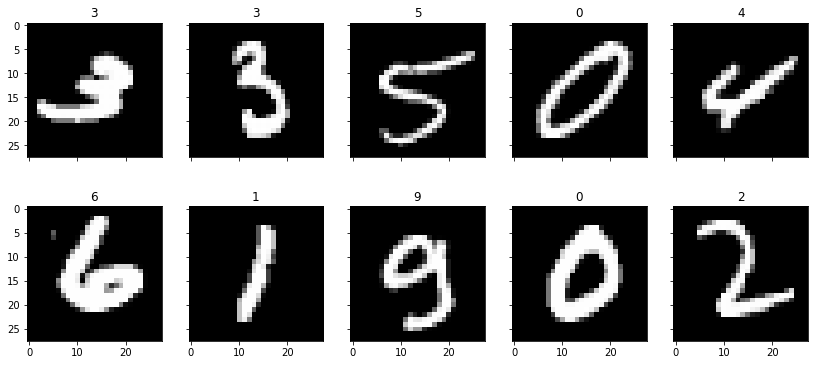

In [7]:
display_10_images_from_dataset(testset, classnames)

In [8]:
def init_weights(shape):
    # xavier initialization (a good initialization is important!)
    # http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization
    fan_in = shape[0]
    fan_out = shape[1]
    variance = 2.0/(fan_in + fan_out)
    w = torch.randn(size=shape)*np.sqrt(variance)
    w.requires_grad = True
    return w

In [9]:
def rectify(X):
    return torch.max(torch.zeros_like(X), X)

In [10]:
# you can also use torch.nn.functional.softmax on future sheets
def softmax(X):
    c = torch.max(X, dim=1)[0].reshape(mb_size, 1)
    # this avoids a blow up of the exponentials
    # but calculates the same formula
    stabelized = X-c
    exp = torch.exp(stabelized)
    return exp/torch.sum(exp, dim=1).reshape(mb_size, 1)

In [11]:
# this is an example as a reduced version of the pytorch internal RMSprop optimizer
class RMSprop(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-4, alpha=0.9, eps=1e-8):
        defaults = dict(lr=lr, alpha=alpha, eps=eps)
        super(RMSprop, self).__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad.data
                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['square_avg'] = torch.zeros_like(p.data)

                square_avg = state['square_avg']
                alpha = group['alpha']

                # update running averages
                square_avg.mul_(alpha).addcmul_(1 - alpha, grad, grad)
                avg = square_avg.sqrt().add_(group['eps'])

                # gradient update
                p.data.addcdiv_(-group['lr'], grad, avg)

In [12]:
def model_basic(X, w_h, w_h2, w_o, p_drop_input, p_drop_hidden):
    #X = dropout(X, p_drop_input)
    h = rectify(X @ w_h)
    #h = dropout(h, p_drop_hidden)
    h2 = rectify(h @ w_h2)
    #h2 = dropout(h2, p_drop_hidden)
    pre_softmax = h2 @ w_o
    return pre_softmax

In [13]:
w_h = init_weights((784, 625))
w_h2 = init_weights((625, 625))
w_o = init_weights((625, 10))

optimizer = RMSprop([w_h, w_h2, w_o], lr=1e-4)

In [14]:
dataloader = trainloader

In [15]:
# define train loop
def train(train_loader, epoch, log_interval, model, p1=0.8, p2=0.7):
    # print to screen every log_interval
    for batch_idx, (data, target) in enumerate(train_loader):
        pre_softmax = model(data.reshape(mb_size, 784), w_h, w_h2, w_o, p1, p2)
        #output = softmax(pre_softmax)
        # note: torch.nn.functional.cross_entropy applies log_softmax
        loss = torch.nn.functional.cross_entropy(pre_softmax, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            #print('pre_soft size: ', pre_softmax.size())
            #print('target size: ', target.size())
            #print('loss size: ', loss.size())
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.4f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data))

# define test loop
def test(test_loader, model):
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        output = model(data.reshape(mb_size, 784), w_h, w_h2, w_o, 1.0, 1.0)
        loss = torch.nn.functional.cross_entropy(output, target) # returns average over minibatch
        test_loss += loss # maybe loss.data[0] ?  # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max probability
        correct += pred.eq(target.data.view_as(pred)).sum() # sum up pair-wise equalities (marked with 1, others 0)

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [16]:
# put this into a training loop over 100 epochs
for epoch in range(0,10):
    train(trainloader, epoch+1, 200, model_basic)
    test(testloader, model_basic)
    

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.4408
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.3066
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.4402
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.2579
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.2007
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.2997

Test set: Average loss: 0.0040, Accuracy: 9388/10000 (93%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.2579
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.2185
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.3849
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.1824
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.0942
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.2576

Test set: Average loss: 0.0036, Accuracy: 9486/10000 (94%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.1828
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.0530
Train Epoch: 3 [20000/60000 (33%)]	Loss: 0.0865
Train Epoch: 3 [30000/60000 (50%)]	Loss: 0.1963
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.1528
Train Epoch: 3 [50000/60000 (83%)]	Loss: 0.3935

Test set: Average loss: 0.00

Since we do not observe an improvement of the network and each epoch takes a significant amount of computational time, we stop after 10 epochs

# 2 Dropout

In [17]:
def dropout(X, p_drop=1.):
    if 0 < p_drop < 1:
        phi = torch.bernoulli(torch.full(X.shape, p_drop))
        X = phi*X/p_drop
        return X.float()
    else:
        return X.float()

In [18]:
def model_dropout(X, w_h, w_h2, w_o, p_drop_input, p_drop_hidden):
    X = dropout(X, p_drop_input)
    h = rectify(X @ w_h)
    h = dropout(h, p_drop_hidden)
    h2 = rectify(h @ w_h2)
    h2 = dropout(h2, p_drop_hidden)
    pre_softmax = h2 @ w_o
    return pre_softmax

In [19]:
w_h = init_weights((784, 625))
w_h2 = init_weights((625, 625))
w_o = init_weights((625, 10))

optimizer = RMSprop([w_h, w_h2, w_o])

In [20]:
# put this into a training loop over 100 epochs
for epoch in range(0,10):
    train(trainloader, epoch+1, 200, model_dropout)
    test(testloader, model_dropout)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.7383
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.4138
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.4144
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.2107
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.4385
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.2747

Test set: Average loss: 0.0044, Accuracy: 9341/10000 (93%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.4805
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.3889
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.4626
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.4177
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.4522
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.5430

Test set: Average loss: 0.0045, Accuracy: 9373/10000 (93%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.6419
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.3810
Train Epoch: 3 [20000/60000 (33%)]	Loss: 0.5625
Train Epoch: 3 [30000/60000 (50%)]	Loss: 0.4755
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.3418
Train Epoch: 3 [50000/60000 (83%)]	Loss: 0.6732

Test set: Average loss: 0.00

(b)
Dropout should in theory improve a networks performance since it prevents interdependencies between different neurons and thereby reduces overfitting as the network learns more robust features.

# 3 Parametric Relu

In [21]:
def PRelu(X,a):
        return torch.where(X > 0, X, a*X)

In [22]:
def model_prelu(X, w_h, w_h2, w_o, a, p_drop_input, p_drop_hidden):
    #X = dropout(X, p_drop_input)
    h = PRelu(X @ w_h, a)
    #h = dropout(h, p_drop_hidden)
    h2 = PRelu(h @ w_h2, a)
    #h2 = dropout(h2, p_drop_hidden)
    pre_softmax = h2 @ w_o
    return pre_softmax

In [23]:
w_h = init_weights((784, 625))
w_h2 = init_weights((625, 625))
w_o = init_weights((625, 10))
a = torch.tensor([+0.1], requires_grad = True)

optimizer = RMSprop([w_h, w_h2, w_o, a])

In [24]:
# put this into a training loop over 100 epochs
for (_, (X, y)) in enumerate(dataloader, 0):
    noise_py_x = model_prelu(X.reshape(mb_size, 784), w_h, w_h2, w_o, a, 0.8, 0.7)
    cost = torch.nn.functional.cross_entropy(noise_py_x, y)
    cost.backward()
    #print("Loss: {:3f}".format(cost))
    print('step: ', _)
    print('loss: %.4f' % cost)
    print('a: %.4f' % a)
    optimizer.step()

step:  0
loss: 2.8695
a: 0.1000
step:  1
loss: 2.6444
a: 0.1003
step:  2
loss: 2.2642
a: 0.1006
step:  3
loss: 2.1641
a: 0.1003
step:  4
loss: 2.2761
a: 0.0999
step:  5
loss: 1.9386
a: 0.0997
step:  6
loss: 1.6756
a: 0.0994
step:  7
loss: 1.5967
a: 0.0992
step:  8
loss: 1.3209
a: 0.0991
step:  9
loss: 1.4423
a: 0.0990
step:  10
loss: 1.2537
a: 0.0989
step:  11
loss: 1.4239
a: 0.0989
step:  12
loss: 1.2187
a: 0.0989
step:  13
loss: 1.0060
a: 0.0989
step:  14
loss: 1.1271
a: 0.0990
step:  15
loss: 0.9518
a: 0.0991
step:  16
loss: 1.0893
a: 0.0993
step:  17
loss: 0.8143
a: 0.0994
step:  18
loss: 0.8337
a: 0.0996
step:  19
loss: 0.8590
a: 0.0998
step:  20
loss: 0.8619
a: 0.1000
step:  21
loss: 0.7422
a: 0.1001
step:  22
loss: 0.7360
a: 0.1003
step:  23
loss: 0.8316
a: 0.1004
step:  24
loss: 0.5170
a: 0.1005
step:  25
loss: 0.7050
a: 0.1007
step:  26
loss: 0.6568
a: 0.1008
step:  27
loss: 0.8379
a: 0.1009
step:  28
loss: 0.8159
a: 0.1011
step:  29
loss: 0.5672
a: 0.1012
step:  30
loss: 0.65

step:  253
loss: 0.2602
a: 0.0841
step:  254
loss: 0.5854
a: 0.0840
step:  255
loss: 0.3106
a: 0.0839
step:  256
loss: 0.3359
a: 0.0838
step:  257
loss: 0.4227
a: 0.0837
step:  258
loss: 0.3912
a: 0.0836
step:  259
loss: 0.4491
a: 0.0834
step:  260
loss: 0.2380
a: 0.0833
step:  261
loss: 0.3762
a: 0.0832
step:  262
loss: 0.7197
a: 0.0831
step:  263
loss: 0.3371
a: 0.0830
step:  264
loss: 0.4006
a: 0.0829
step:  265
loss: 0.3642
a: 0.0828
step:  266
loss: 0.4813
a: 0.0827
step:  267
loss: 0.1526
a: 0.0826
step:  268
loss: 0.3358
a: 0.0825
step:  269
loss: 0.1905
a: 0.0824
step:  270
loss: 0.3461
a: 0.0823
step:  271
loss: 0.2367
a: 0.0822
step:  272
loss: 0.1619
a: 0.0821
step:  273
loss: 0.2477
a: 0.0820
step:  274
loss: 0.2093
a: 0.0819
step:  275
loss: 0.6187
a: 0.0818
step:  276
loss: 0.2599
a: 0.0817
step:  277
loss: 0.2628
a: 0.0816
step:  278
loss: 0.4253
a: 0.0815
step:  279
loss: 0.3503
a: 0.0814
step:  280
loss: 0.2659
a: 0.0812
step:  281
loss: 0.3310
a: 0.0811
step:  282
los

step:  499
loss: 0.2109
a: 0.0584
step:  500
loss: 0.2357
a: 0.0583
step:  501
loss: 0.6648
a: 0.0582
step:  502
loss: 0.2000
a: 0.0581
step:  503
loss: 0.2157
a: 0.0580
step:  504
loss: 0.5423
a: 0.0579
step:  505
loss: 0.5822
a: 0.0578
step:  506
loss: 0.4235
a: 0.0577
step:  507
loss: 0.6527
a: 0.0576
step:  508
loss: 0.2446
a: 0.0575
step:  509
loss: 0.1842
a: 0.0574
step:  510
loss: 0.2776
a: 0.0573
step:  511
loss: 0.2527
a: 0.0572
step:  512
loss: 0.2808
a: 0.0571
step:  513
loss: 0.2451
a: 0.0570
step:  514
loss: 0.2110
a: 0.0569
step:  515
loss: 0.1546
a: 0.0568
step:  516
loss: 0.2203
a: 0.0567
step:  517
loss: 0.1267
a: 0.0566
step:  518
loss: 0.6799
a: 0.0565
step:  519
loss: 0.4170
a: 0.0564
step:  520
loss: 0.1625
a: 0.0563
step:  521
loss: 0.3857
a: 0.0561
step:  522
loss: 0.4404
a: 0.0560
step:  523
loss: 0.2860
a: 0.0559
step:  524
loss: 0.3420
a: 0.0558
step:  525
loss: 0.1183
a: 0.0557
step:  526
loss: 0.3281
a: 0.0556
step:  527
loss: 0.2367
a: 0.0555
step:  528
los

a: 0.0327
step:  753
loss: 0.1376
a: 0.0326
step:  754
loss: 0.2635
a: 0.0325
step:  755
loss: 0.2925
a: 0.0324
step:  756
loss: 0.2000
a: 0.0323
step:  757
loss: 0.1995
a: 0.0322
step:  758
loss: 0.1545
a: 0.0321
step:  759
loss: 0.0560
a: 0.0320
step:  760
loss: 0.4216
a: 0.0319
step:  761
loss: 0.5103
a: 0.0318
step:  762
loss: 0.1678
a: 0.0317
step:  763
loss: 0.1046
a: 0.0316
step:  764
loss: 0.2829
a: 0.0315
step:  765
loss: 0.2714
a: 0.0314
step:  766
loss: 0.1551
a: 0.0313
step:  767
loss: 0.3221
a: 0.0312
step:  768
loss: 0.1445
a: 0.0311
step:  769
loss: 0.2356
a: 0.0310
step:  770
loss: 0.2047
a: 0.0309
step:  771
loss: 0.1800
a: 0.0308
step:  772
loss: 0.0576
a: 0.0307
step:  773
loss: 0.1544
a: 0.0306
step:  774
loss: 0.1457
a: 0.0305
step:  775
loss: 0.2190
a: 0.0304
step:  776
loss: 0.4300
a: 0.0303
step:  777
loss: 0.2516
a: 0.0302
step:  778
loss: 0.1178
a: 0.0301
step:  779
loss: 0.2166
a: 0.0300
step:  780
loss: 0.3147
a: 0.0299
step:  781
loss: 0.3132
a: 0.0298
step

step:  994
loss: 0.2734
a: 0.0083
step:  995
loss: 0.2718
a: 0.0082
step:  996
loss: 0.3278
a: 0.0081
step:  997
loss: 0.3749
a: 0.0080
step:  998
loss: 0.1701
a: 0.0079
step:  999
loss: 0.2717
a: 0.0078
step:  1000
loss: 0.1175
a: 0.0077
step:  1001
loss: 0.2728
a: 0.0076
step:  1002
loss: 0.1936
a: 0.0076
step:  1003
loss: 0.1517
a: 0.0075
step:  1004
loss: 0.1753
a: 0.0074
step:  1005
loss: 0.1013
a: 0.0073
step:  1006
loss: 0.2378
a: 0.0072
step:  1007
loss: 0.2896
a: 0.0071
step:  1008
loss: 0.1855
a: 0.0071
step:  1009
loss: 0.2725
a: 0.0070
step:  1010
loss: 0.2275
a: 0.0069
step:  1011
loss: 0.1296
a: 0.0068
step:  1012
loss: 0.4042
a: 0.0067
step:  1013
loss: 0.1108
a: 0.0066
step:  1014
loss: 0.2529
a: 0.0065
step:  1015
loss: 0.3133
a: 0.0064
step:  1016
loss: 0.1841
a: 0.0063
step:  1017
loss: 0.1481
a: 0.0062
step:  1018
loss: 0.2028
a: 0.0061
step:  1019
loss: 0.1102
a: 0.0060
step:  1020
loss: 0.3476
a: 0.0059
step:  1021
loss: 0.1244
a: 0.0058
step:  1022
loss: 0.1806
a

As one can see, the PRelu parameter ```a``` is optimized in each step.

# 4. Convolutional layers

We use the following code snippets to build the convolutional network:

```python
    from torch . nn . functional import conv2d , max_pool2d
    convolutional_layer = rectify ( conv2d ( previous_layer , weightvector ))
    subsampleing_layer = max_pool_2d ( convolutional_layer , (2 , 2) ) # reduces window 2x2 to 1 pixel
    out_layer = dropout ( subsample_layer , p_drop_input )
```

In [25]:
from torch.nn.functional import conv2d, max_pool2d

lr = 2e-5

# given on exercise sheet
f1, f2, f3 = 32, 64, 128
pic_in1, pic_in2, pic_in3 = 1, 32, 64 
k_x1, k_x2, k_x3 = 5, 5, 2
k_y1, k_y2, k_y3 = 5, 5, 2

# modify for more speed
#f1, f2, f3 = 20, 40, 80
#pic_in1, pic_in2, pic_in3 = 1, 20, 40
#k_x1, k_x2, k_x3 = 5, 5, 2
#k_y1, k_y2, k_y3 = 5, 5, 2


activation = 'prelu'


w_conv1 = init_weights((f1, pic_in1, k_x1, k_y1))
w_conv2 = init_weights((f2, pic_in2, k_x2, k_y2))
w_conv3 = init_weights((f3, pic_in3, k_x3, k_y3))

def conv_layer(X, weightvector, p_drop):
    X = rectify(conv2d (X, weightvector))
    X = max_pool2d(X, (2 , 2)) # reduces window 2x2 to 1 pixel
    return dropout(X, p_drop)

def get_num_output_pix(w_conv1, w_conv2, w_conv3, p_drop_input):
    def cnn_pre(X, w_conv1, w_conv2, w_conv3, p_drop_input):
        X = conv_layer(X, w_conv1, p_drop_input)
        X = conv_layer(X, w_conv2, p_drop_input)
        X = conv_layer(X, w_conv3, p_drop_input)
        return X
    Y = torch.randn((mb_size, 1, 28, 28)) # standard mnist tensor size
    # get output size
    Y = cnn_pre(Y, w_conv1, w_conv2, w_conv3, p_drop_input)
    return Y.size()[1]

number_of_output_pixels = get_num_output_pix(w_conv1, w_conv2, w_conv3, 0.5)
print('number of output pixels = ', number_of_output_pixels)

# given on exercise sheet
w_h2 = init_weights((number_of_output_pixels, 625))
w_o = init_weights((625, 10))

# modify for more speed
w_h2 = init_weights((number_of_output_pixels, 250))
w_o = init_weights((250, 10))

# in case pReLU is needed:
if activation == 'prelu':
    a = torch.tensor([0.01], requires_grad = True)
elif activation == 'relu':
    a = torch.tensor([0.], requires_grad = False)
else:
    print('Please enter valid activation function (either relu or prelu)')

if activation == 'prelu':
    optimizer = RMSprop([w_conv1, w_conv2, w_conv3, w_h2, w_o, a], lr = lr)
elif activation == 'relu':
    optimizer = RMSprop([w_conv1, w_conv2, w_conv3, w_h2, w_o], lr = lr)
else:
    print('Please enter valid activation function (either relu or prelu)')    

# add a here if running with pReLU
def cnn(X, w_conv1, w_conv2, w_conv3, w_h2, w_o, p_drop_input, p_drop_hidden):
    X = conv_layer(X, w_conv1, p_drop_input)
    X = conv_layer(X, w_conv2, p_drop_input)
    X = conv_layer(X, w_conv3, p_drop_input)
    X = X.reshape(mb_size, number_of_output_pixels)
    h2 = PRelu(X @ w_h2, a)
    h2 = dropout(h2, p_drop_hidden)
    pre_softmax = h2 @ w_o
    return pre_softmax

number of output pixels =  128


In [26]:
# define train loop
def train(train_loader, epoch, log_interval):
    # print to screen every log_interval
    for batch_idx, (data, target) in enumerate(train_loader):
        pre_softmax = cnn(data.reshape(-1, 1, 28, 28), w_conv1, w_conv2, w_conv3, w_h2, w_o, 0.8, 0.7)
        #output = softmax(pre_softmax)
        # note: torch.nn.functional.cross_entropy applies log_softmax
        loss = torch.nn.functional.cross_entropy(pre_softmax, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            #print('pre_soft size: ', pre_softmax.size())
            #print('target size: ', target.size())
            #print('loss size: ', loss.size())
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.4f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data))

# define test loop
def test(test_loader):
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        output = cnn(data.reshape(-1, 1, 28, 28), w_conv1, w_conv2, w_conv3, w_h2, w_o, 1., 1.)
        loss = torch.nn.functional.cross_entropy(output, target) # returns average over minibatch
        test_loss += loss # maybe loss.data[0] ?  # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max probability
        correct += pred.eq(target.data.view_as(pred)).sum() # sum up pair-wise equalities (marked with 1, others 0)

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [27]:
def run_model(train_loader, test_loader, num_epochs, log_interval):
    # run training
    t1 = time.time()
    for epoch in range(1, num_epochs + 1):
        train(train_loader, epoch, log_interval)
        test(test_loader)       
    t2 = time.time()
    print('Training took {:.1f} seconds (or {:.1f} minutes)'.format(t2 - t1, (t2 - t1) / 60))

In [28]:
N_epochs = 10
log_interval = 200

run_model(trainloader, testloader, N_epochs, log_interval)

Train Epoch: 1 [0/60000 (0%)]	Loss: 14.3096
Train Epoch: 1 [10000/60000 (17%)]	Loss: 4.7954
Train Epoch: 1 [20000/60000 (33%)]	Loss: 2.2498
Train Epoch: 1 [30000/60000 (50%)]	Loss: 2.1114
Train Epoch: 1 [40000/60000 (67%)]	Loss: 2.1827
Train Epoch: 1 [50000/60000 (83%)]	Loss: 2.0474

Test set: Average loss: 0.0410, Accuracy: 4479/10000 (44%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.0793
Train Epoch: 2 [10000/60000 (17%)]	Loss: 1.9478
Train Epoch: 2 [20000/60000 (33%)]	Loss: 1.8250
Train Epoch: 2 [30000/60000 (50%)]	Loss: 1.7619
Train Epoch: 2 [40000/60000 (67%)]	Loss: 1.4983
Train Epoch: 2 [50000/60000 (83%)]	Loss: 1.3147

Test set: Average loss: 0.0196, Accuracy: 7359/10000 (73%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 1.3836
Train Epoch: 3 [10000/60000 (17%)]	Loss: 1.2182
Train Epoch: 3 [20000/60000 (33%)]	Loss: 1.1300
Train Epoch: 3 [30000/60000 (50%)]	Loss: 1.2226
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.9618
Train Epoch: 3 [50000/60000 (83%)]	Loss: 1.0778

Test set: Average loss: 0.0

In [29]:
print(a)

tensor(1.00000e-03 *
       [ 5.2599])


By printing a to the screen we see that it is indeed modified during training (initial value: a = 0.01)

## issues:
 - find nice hyperparameters (learning rate, dropout, ...)

# 4.2 Application of Convolutional Network

First, we sketch the network architecure in order to determine the number of neurons in the last layer. For this purpose we have to take into account the following:<br>
<ul>
<li>Convolving an (n x n) image with a (5 x 5) filter without padding produces an output of dimension (n-4 x n-4) since we lose 2 pixels on each side of the image.</li>
<li>Applying a (2 x 2) max pooling layer on  a (n x n) image gives an (n/2 x n/2) output.</li>
<li>Convolving an (n x n) image with a (2 x 2) filter witout padding produces an output of dimension (n-1 x n-1).</li>
<li>In the last step, we apply a (2 x 2) pooling operation on a (3 x 3) image where the dimensions of filter and image do not really match. Nevertheless we obtain a (1 x 1) output, but maybe, it would be more convenient to apply a (3 x 3) filter in the previous layer such that we could apply the (2 x 2) pooling to a (2 x 2) image?</li>
</ul>
Taking all this into account, we obtain the architecture displayed below and can read off that the last convolutional layer contains (128 x 1 x 1) = 128 pixels.

(-0.5, 2546.5, 782.5, -0.5)

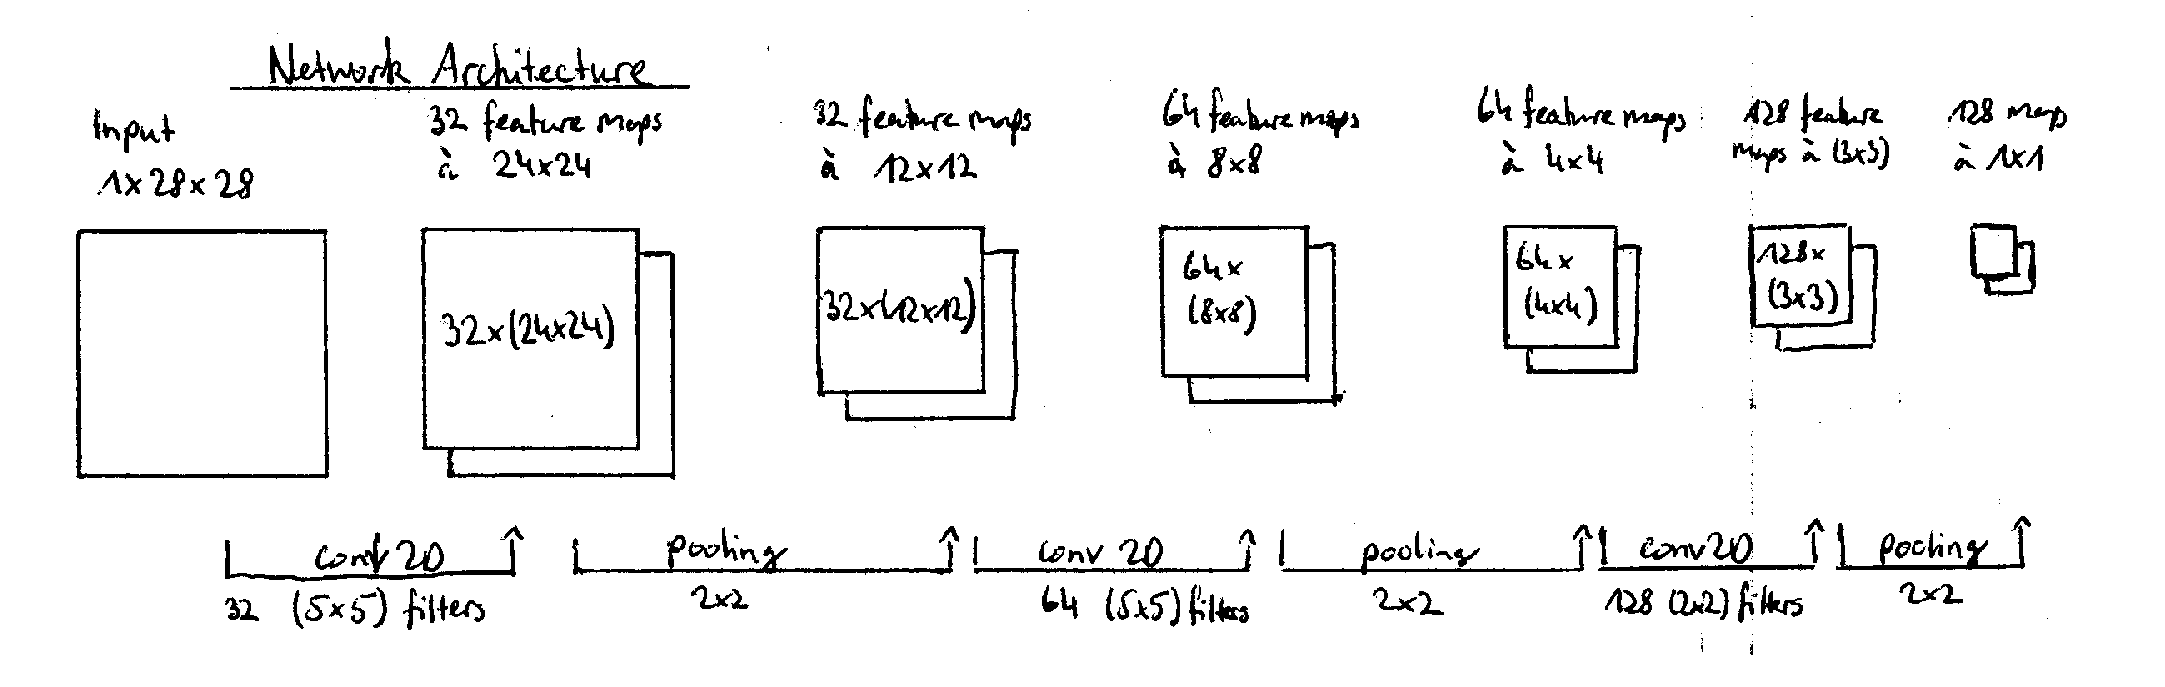

In [30]:
architecture = plt.imread('architecture.png')
fig, ax = plt.subplots(figsize=(40,12))
ax.imshow(architecture)
plt.axis('off')

Now, we visualize one image of the test set, its convolution with 3 filters of the first convolutional layer and the corresponding filter weights.

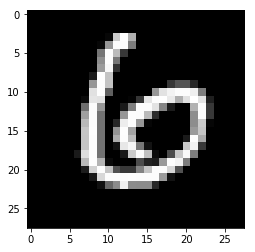

In [31]:
index = 11
selected_image = testset[index]
plt.imshow(selected_image[0][0], cmap='gray')

In [32]:
filters_of_interest = torch.tensor([4,5,0])
print(selected_image[0].size())
feature_maps = conv2d(selected_image[0].unsqueeze(0), w_conv1[filters_of_interest,:,:,:])
print(feature_maps.size())
feature_maps = feature_maps.detach()  # detach from comp. graph
filters = w_conv1.detach()
print(filters.size())

torch.Size([1, 28, 28])
torch.Size([1, 3, 24, 24])
torch.Size([32, 1, 5, 5])


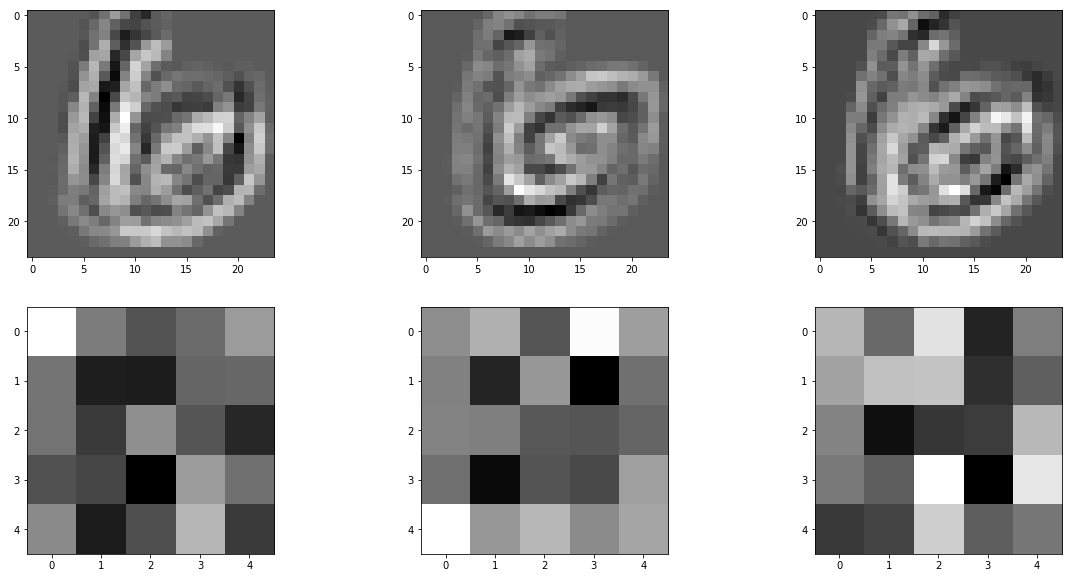

In [33]:
fig1, ax1 = plt.subplots(2,3, figsize=(20,10))
for i in range(3):
    ax1[0,i].imshow(feature_maps[0,i,:,:], cmap='gray')
    ax1[1,i].imshow(filters[filters_of_interest[i]][0], cmap='gray')

In the upper row we show the feature maps which have been obtained by convolving the input image with the three filters shown in the lower row.<br>
We can see that the left filter detects vertical edges wheread the central filter detects horizontal edges.

## For comparison: feature maps and filters with no training

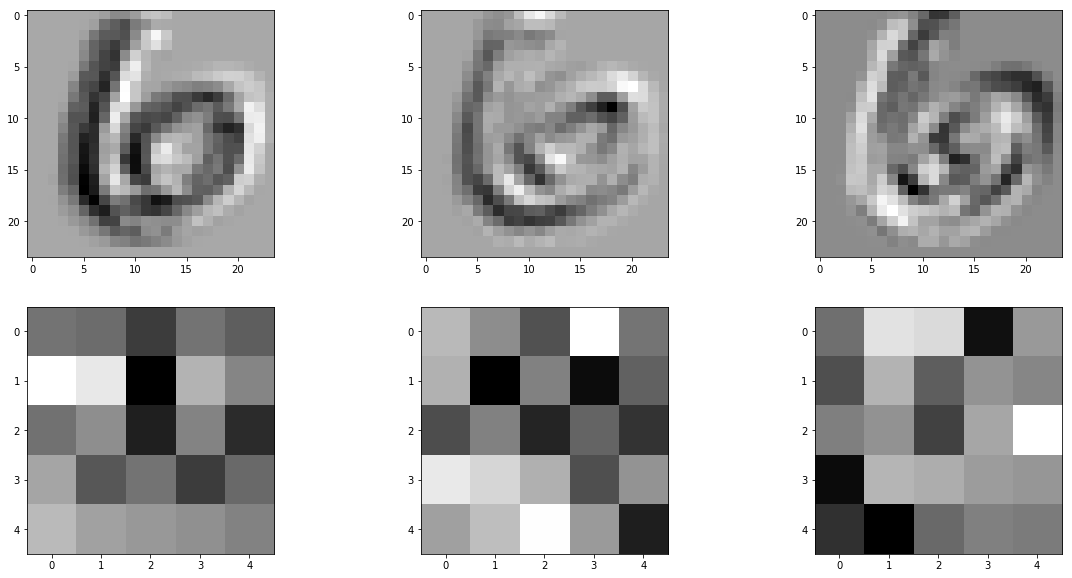

In [34]:
w_conv1 = init_weights((f1, pic_in1, k_x1, k_y1))
filters_of_interest = torch.tensor([1,2,3])
feature_maps = conv2d(selected_image[0].unsqueeze(0), w_conv1[filters_of_interest,:,:,:])
feature_maps = feature_maps.detach()  # detach from comp. graph
filters = w_conv1.detach()

fig1, ax1 = plt.subplots(2,3, figsize=(20,10))
for i in range(3):
    ax1[0,i].imshow(feature_maps[0,i,:,:], cmap='gray')
    ax1[1,i].imshow(filters[filters_of_interest[i]][0], cmap='gray')

# Try different network architecture

### 1. add additional convolutional layer

#### parameter initialization

In [35]:
from torch.nn.functional import conv2d, max_pool2d

lr = 2e-5

# given on exercise sheet
f1, f2 = 32, 64
pic_in1, pic_in2 = 1, 32 
k_x1, k_x2 = 5, 5
k_y1, k_y2 = 5, 5

activation = 'prelu'


w_conv1 = init_weights((f1, pic_in1, k_x1, k_y1))
w_conv2 = init_weights((f2, pic_in2, k_x2, k_y2))

def conv_layer(X, weightvector, p_drop):
    X = rectify(conv2d (X, weightvector))
    X = max_pool2d(X, (2 , 2)) # reduces window 2x2 to 1 pixel
    return dropout(X, p_drop)

def get_num_output_pix(w_conv1, w_conv2, p_drop_input):
    def cnn_pre(X, w_conv1, w_conv2, p_drop_input):
        X = conv_layer(X, w_conv1, p_drop_input)
        X = conv_layer(X, w_conv2, p_drop_input)
        return X
    Y = torch.randn((mb_size, 1, 28, 28)) # standard mnist tensor size
    # get output size
    Y = cnn_pre(Y, w_conv1, w_conv2, p_drop_input)
    return Y.size()[1]*Y.size()[2]*Y.size()[3]

number_of_output_pixels = get_num_output_pix(w_conv1, w_conv2, 0.5)
print('number of output pixels = ', number_of_output_pixels)

# given on exercise sheet
w_h2 = init_weights((number_of_output_pixels, 625))
w_o = init_weights((625, 10))

# modify for more speed
w_h2 = init_weights((number_of_output_pixels, 250))
w_o = init_weights((250, 10))

# in case pReLU is needed:
if activation == 'prelu':
    a = torch.tensor([0.01], requires_grad = True)
elif activation == 'relu':
    a = torch.tensor([0.], requires_grad = False)
else:
    print('Please enter valid activation function (either relu or prelu)')

if activation == 'prelu':
    optimizer = RMSprop([w_conv1, w_conv2, w_h2, w_o, a], lr = lr)
elif activation == 'relu':
    optimizer = RMSprop([w_conv1, w_conv2, w_h2, w_o], lr = lr)
else:
    print('Please enter valid activation function (either relu or prelu)')    

# add a here if running with pReLU
def cnn(X, w_conv1, w_conv2, w_h2, w_o, p_drop_input, p_drop_hidden):
    X = conv_layer(X, w_conv1, p_drop_input)
    X = conv_layer(X, w_conv2, p_drop_input)
    X = X.reshape(mb_size, number_of_output_pixels)
    h2 = PRelu(X @ w_h2, a)
    h2 = dropout(h2, p_drop_hidden)
    pre_softmax = h2 @ w_o
    return pre_softmax

# define train loop
def train(train_loader, epoch, log_interval):
    # print to screen every log_interval
    for batch_idx, (data, target) in enumerate(train_loader):
        pre_softmax = cnn(data.reshape(-1, 1, 28, 28), w_conv1, w_conv2, w_h2, w_o, 0.8, 0.7)
        #output = softmax(pre_softmax)
        # note: torch.nn.functional.cross_entropy applies log_softmax
        loss = torch.nn.functional.cross_entropy(pre_softmax, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            #print('pre_soft size: ', pre_softmax.size())
            #print('target size: ', target.size())
            #print('loss size: ', loss.size())
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.4f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data))

# define test loop
def test(test_loader):
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        output = cnn(data.reshape(-1, 1, 28, 28), w_conv1, w_conv2, w_h2, w_o, 1., 1.)
        loss = torch.nn.functional.cross_entropy(output, target) # returns average over minibatch
        test_loss += loss # maybe loss.data[0] ?  # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max probability
        correct += pred.eq(target.data.view_as(pred)).sum() # sum up pair-wise equalities (marked with 1, others 0)

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

number of output pixels =  1024


#### running the model

In [36]:
N_epochs = 10
log_interval = 200

run_model(trainloader, testloader, N_epochs, log_interval)

Train Epoch: 1 [0/60000 (0%)]	Loss: 13.7446
Train Epoch: 1 [10000/60000 (17%)]	Loss: 1.8366
Train Epoch: 1 [20000/60000 (33%)]	Loss: 1.2868
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.6374
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.5670
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.6007

Test set: Average loss: 0.0067, Accuracy: 8983/10000 (89%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.4190
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.6261
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.3500
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.2013
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.5761
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.4281

Test set: Average loss: 0.0035, Accuracy: 9474/10000 (94%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.3171
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.4084
Train Epoch: 3 [20000/60000 (33%)]	Loss: 0.2153
Train Epoch: 3 [30000/60000 (50%)]	Loss: 0.4661
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.2715
Train Epoch: 3 [50000/60000 (83%)]	Loss: 0.7973

Test set: Average loss: 0.0

we observe, what we believe to be faster fitting due to less layers. The original CNN should perform better with significantly more than 10 epochs.